## A Probabilistic Policy
We develop a policy function that maps a board to a probabilistic distribution over good actions. We use the heuristic scoring system from ```HeuristicPolicy.py``` and ```Heuristic.py```. The trick is to have a prioritized approach that considers the criticality categories top down. Only if there's no field belonging to a higher category, then any lower category or the original score can be considered. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from wgomoku import (
    GomokuBoard, Move, StochasticMaxSampler, HeuristicGomokuPolicy, 
    ThreatSearch, Heuristics, GomokuTools as gt)


In [3]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

In [4]:
h = Heuristics(kappa=3.0)

In [5]:
board = GomokuBoard(h, N=20, disp_width=10)
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5, threat_search=ThreatSearch(5,3))
board.set(I,10).set(H,9).set(J,9).set(H,11).set(K,10).set(J,10);

The probabilistic distribution is provided by ```HeuristicGomokuPolicy.probas```

In [6]:
import inspect
lines = inspect.getsource(HeuristicGomokuPolicy.probas)
print(lines)

    def probas (self, board, style):
        """    
        Returns the (suggested) probabilities for a move to be taken.
        In case, masks all but the positions belonging to the most critical category. 
        Params:
        board: a gomoku board.
        style: 0=aggressive, 1=defensive, 2=mixed
        In non-critical situations, style = 0 looks at offensive options only,
        style = 1 looks at defensive options only and style = 2 considers both aspects
        equally.
        """
        scores = board.get_clean_scores()
        to_move = 1 - board.current_color
        o = scores[to_move]
        d = scores[1 - to_move]

        criticals = [lambda: o > 7.0, lambda: d > 7.0,
                     lambda: o == 7.0, lambda: d == 7.0,
                     lambda: o == 6.9, lambda: d == 6.9]

        for crit in criticals:
            field = crit()
            if field.any():
                return field / field.sum()

        if style == 0:
            noncrit = scores[t

-5.050153242075339

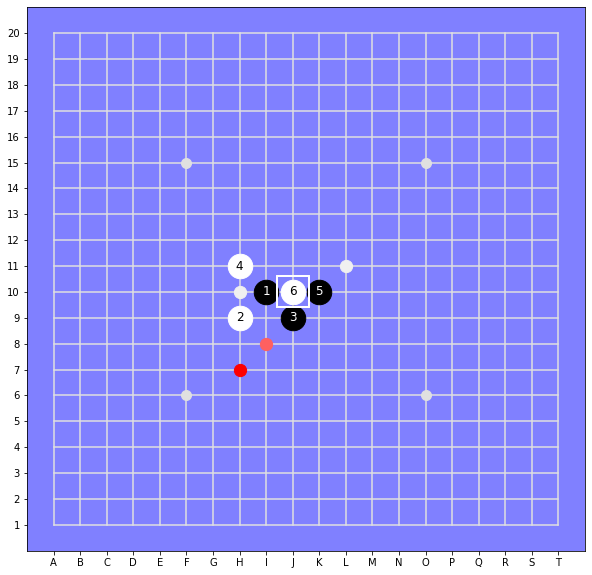

In [7]:
board.display(probas=lambda x: p.probas(x, 2))
board.get_value(True)

In [8]:
board.set(H, 7);

-30.72068268501276

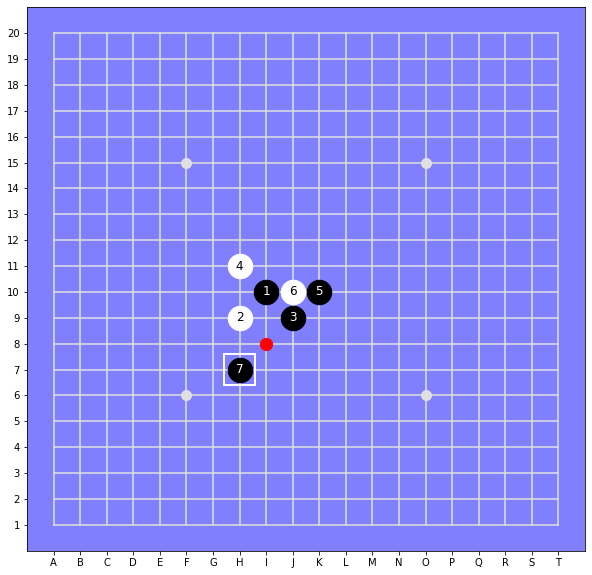

In [9]:
board.display(probas=lambda x: p.probas(x, 1))
board.get_value(True)

---
### Let the games begin!
We use a ```StochasticMaxSampler``` to sample from the board's distribution function . The idea behind the below self-play is that the players follow a common policy that handles critical situations appropriately and suggests kind of value-based moves, otherwise. Both parties check the field for potential threat sequences before they engage in rather loose (bias=0.5) tactical moves.

In [20]:
board = GomokuBoard(h, N=20, disp_width=10)
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5, 
                          threat_search=ThreatSearch(6,5))
board.set(I,10).set(H,9).set(J,9).set(H,11).set(K,10).set(J,10);
ts = ThreatSearch(max_depth=4, max_width=5)

Thread sequence: [(6, 11), (7, 10), (9, 11), (7, 11), (8, 12), (11, 9), (8, 10)]: 
Thread sequence: [(9, 11), (7, 11), (8, 12), (7, 13), (8, 10)]: 
Thread sequence: [(8, 12), (7, 13), (8, 10)]: 
White wins.
CPU times: user 8.36 s, sys: 280 ms, total: 8.64 s
Wall time: 8.65 s


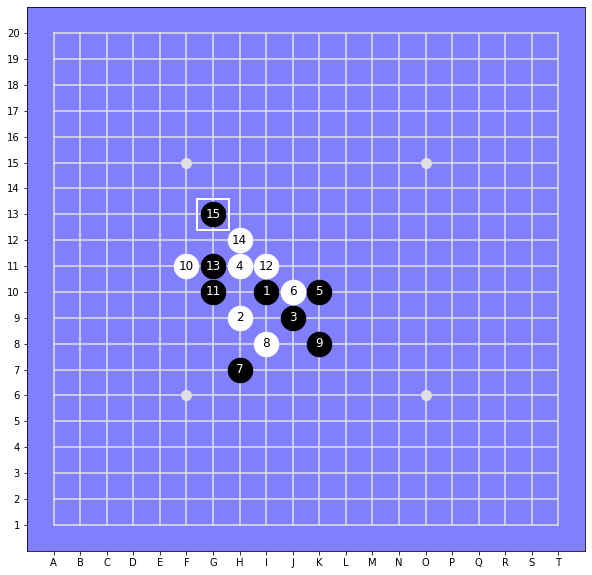

In [21]:
def play(N):
    colors = ['Black', 'White']
    for i in range(N):
        moves, won = ts.is_tseq_won(board)
        if won:
            x, y = moves[0]
            print ("Thread sequence: %s: " % moves)
        else:
            probas = p.probas(board, 2)
            sampler = StochasticMaxSampler(np.ndenumerate(probas), bias=0.5, topn=5)
            move = sampler.draw()
            x, y = gt.m2b(move, size=20)
        board.set(x,y)

        status = board.game_state()
        if status == 1: 
            print("%s wins." % colors[1 - board.current_color])
            break
        elif status == -1: 
            print("%s lost." % colors[1 - board.current_color])
            break
%time play(40)
board.display()